In [1]:
import pickle
import numpy as np
import scipy.ndimage as ndimage
import networkx as nx
import torch
import torch_geometric as pyg
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torch.nn import Sequential, ReLU, Module
from torch_geometric.nn import GCNConv

from flygym.util.data import ommatidia_id_map_path, sample_visual_path
from flygym.util.vision import (
    raw_image_to_hex_pxls,
    hex_pxls_to_human_readable,
    num_pixels_per_ommatidia,
)

In [2]:
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

Load the ommatidia ID map: a raster with integer pixel values indicating the ID of the ommatidium.

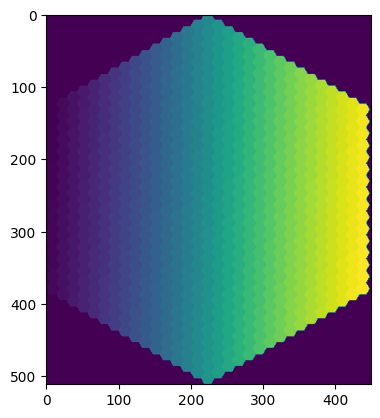

In [3]:
ommatidia_id_map = np.load(ommatidia_id_map_path)
plt.imshow(ommatidia_id_map)

For each ommatidium, dilate the mask by a few pixels and find the IDs of its neighbors.

In [4]:
dilation_kernel = np.ones((5, 5), dtype=bool)

edges = set()
node_pos = dict()
for ommatidium_id in range(1, ommatidia_id_map.max() + 1):
    mask = ommatidia_id_map == ommatidium_id
    node_pos[ommatidium_id] = np.mean(np.argwhere(mask), axis=0)
    dilated_mask = ndimage.binary_dilation(mask, dilation_kernel)
    neighbor_ids = np.unique(ommatidia_id_map[dilated_mask])
    for neighbor_id in neighbor_ids:
        if neighbor_id not in [0, ommatidium_id]:
            pair = sorted([ommatidium_id, neighbor_id])
            edges.add(tuple(pair))

In [5]:
graph = nx.from_edgelist(edges)

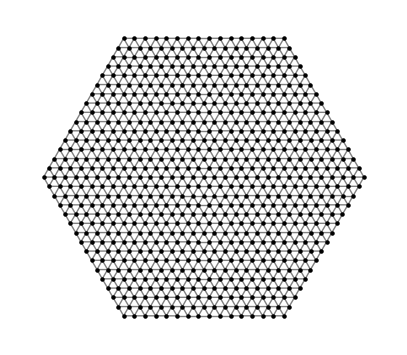

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))
nx.draw(
    graph,
    pos=node_pos,
    node_size=5,
    width=1,
    node_color="black",
    edge_color="gray",
    ax=ax,
)
ax.set_aspect("equal")

In [7]:
with open("ommatidia_grid_graph.pkl", "wb") as f:
    pickle.dump(graph, f)

## Demo: doing graph convolution on an image input

First, load the example image

In [8]:
sample_img = np.array(Image.open(sample_visual_path))
ommatidia_intensities = raw_image_to_hex_pxls(
    sample_img, num_pixels_per_ommatidia, ommatidia_id_map
)
human_readable_img = hex_pxls_to_human_readable(ommatidia_intensities, ommatidia_id_map)

Shape of ommatidia intensities: (721, 2)


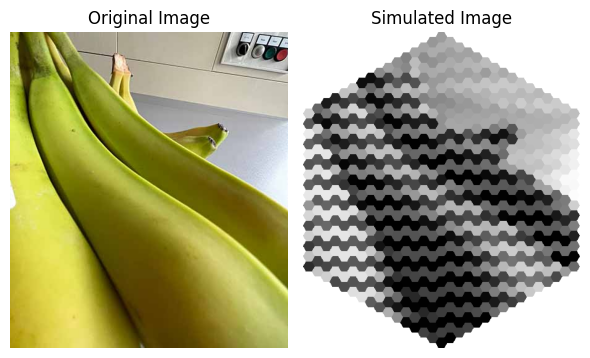

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(6, 5), tight_layout=True)
axs[0].imshow(sample_img)
axs[0].axis("off")
axs[0].set_title("Original Image")
axs[1].imshow(human_readable_img, cmap="gray", vmin=0, vmax=255)
axs[1].axis("off")
axs[1].set_title("Simulated Image")

print(f"Shape of ommatidia intensities: {ommatidia_intensities.shape}")

Build PyG graph

In [10]:
pg_graph = pyg.utils.from_networkx(graph)
pg_graph

Data(edge_index=[2, 4140], num_nodes=721)

Define the Graph Convolutional Network (GCN)

In [11]:
class MyModel(Module):
    def __init__(self, in_channels=2, hidden_channels=8, out_channels=4):
        super(MyModel, self).__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, ommatidia_intensity, graph):
        ommatidia_intensity = ommatidia_intensity.view(-1, self.in_channels)
        x = self.conv1(ommatidia_intensity, graph.edge_index)
        x = x.relu()
        x = self.conv2(x, graph.edge_index)
        return x

Run the GCN on the input

In [12]:
model = MyModel()
inputs = torch.tensor(ommatidia_intensities, dtype=torch.float)
outputs = model(inputs, pg_graph).cpu().detach().numpy()

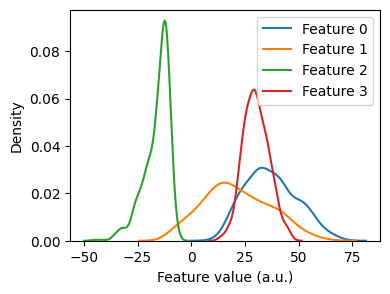

In [13]:
plt.figure(figsize=(4, 3))
for i in range(outputs.shape[1]):
    sns.kdeplot(outputs[:, i], label=f"Feature {i}")
plt.xlabel("Feature value (a.u.)")
plt.legend()

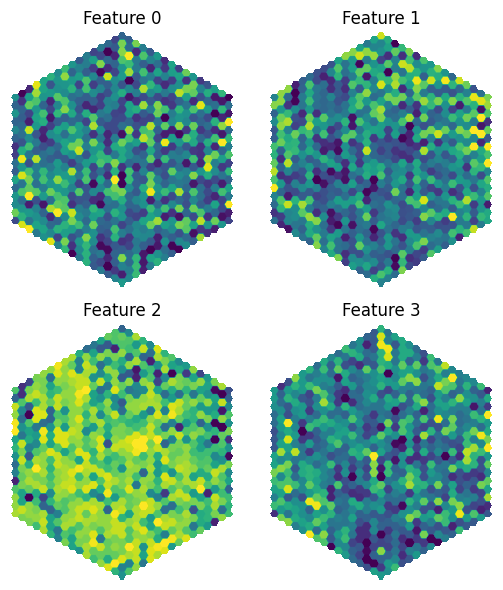

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6), tight_layout=True)

for i, ax in enumerate(axs.reshape(-1)):
    feature_layer = outputs[:, i]
    vmin, vmax = np.percentile(feature_layer, [1, 99])
    layer_repeated = np.repeat(feature_layer.reshape(-1, 1), 2, axis=1)
    human_readable_layer = hex_pxls_to_human_readable(layer_repeated, ommatidia_id_map)
    human_readable_layer = human_readable_layer.astype(float)
    human_readable_layer[ommatidia_id_map == 0] = np.nan
    ax.imshow(human_readable_layer, vmin=vmin, vmax=vmax)
    ax.axis("off")
    ax.set_aspect("equal")
    ax.set_title(f"Feature {i}")